# 03 — Probability of Default (PD) Modeling

**Objective**: Build, tune, and evaluate PD models for Lending Club loans.

**Pipeline**:
1. Load feature-engineered data (from NB02)
2. Logistic Regression baseline
3. CatBoost default configuration
4. Optuna hyperparameter optimization (50 trials)
5. SHAP explainability
6. Probability calibration (Isotonic, Platt)
7. Full evaluation: AUC, KS, Gini, Brier, ECE

**Validation**: Out-of-Time split — Train (<2018) → Test (2018+)

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pickle
import time
from pathlib import Path
from loguru import logger

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, roc_curve, brier_score_loss,
    precision_recall_curve, average_precision_score,
    classification_report
)
from sklearn.calibration import calibration_curve
from catboost import CatBoostClassifier, Pool

from src.evaluation.metrics import classification_metrics, ks_statistic
from src.models.calibration import (
    expected_calibration_error, calibrate_isotonic,
    evaluate_calibration
)

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams.update({"figure.figsize": (12, 6), "figure.dpi": 100})

DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(exist_ok=True)

print("Setup complete.")

Setup complete.


---
## 1. Load Data & Define Feature Sets

We load the feature-engineered datasets from NB02. If `train_fe.parquet` doesn't exist yet, we fall back to running the feature engineering pipeline inline.

In [2]:
# Try to load pre-engineered data, fallback to raw + inline FE
if (DATA_DIR / "train_fe.parquet").exists():
    train = pd.read_parquet(DATA_DIR / "train_fe.parquet")
    cal = pd.read_parquet(DATA_DIR / "calibration_fe.parquet")
    test = pd.read_parquet(DATA_DIR / "test_fe.parquet")
    print("Loaded feature-engineered datasets from NB02.")

    # Load feature config
    with open(DATA_DIR / "feature_config.pkl", "rb") as f:
        feat_config = pickle.load(f)
    CATBOOST_FEATURES = feat_config["CATBOOST_FEATURES"]
    LOGREG_FEATURES = feat_config["LOGREG_FEATURES"]
    CAT_FEATURES = feat_config["CATEGORICAL_FEATURES"].copy()

    # Interaction features (e.g. int_rate_bucket__grade) are string columns
    # that must also be declared as categorical for CatBoost
    if "INTERACTION_FEATURES" in feat_config:
        for f in feat_config["INTERACTION_FEATURES"]:
            if f in CATBOOST_FEATURES and f not in CAT_FEATURES:
                CAT_FEATURES.append(f)
else:
    print("Feature-engineered files not found. Running NB02 pipeline inline...")
    # Load raw and apply feature engineering
    train = pd.read_parquet(DATA_DIR / "train.parquet")
    cal = pd.read_parquet(DATA_DIR / "calibration.parquet")
    test = pd.read_parquet(DATA_DIR / "test.parquet")

    # Minimal cleaning
    for df_ref in [train, cal, test]:
        if df_ref["int_rate"].dtype == object:
            df_ref["int_rate"] = df_ref["int_rate"].astype(str).str.rstrip("%").pipe(pd.to_numeric, errors="coerce")
        if df_ref["term"].dtype == object:
            df_ref["term"] = df_ref["term"].astype(str).str.extract(r"(\d+)")[0].pipe(pd.to_numeric, errors="coerce")
        if "revol_util" in df_ref.columns and df_ref["revol_util"].dtype == object:
            df_ref["revol_util"] = df_ref["revol_util"].astype(str).str.rstrip("%").pipe(pd.to_numeric, errors="coerce")

    # Minimal features
    from src.features.feature_engineering import run_feature_pipeline
    train = run_feature_pipeline(train)
    cal = run_feature_pipeline(cal)
    test = run_feature_pipeline(test)

    CATBOOST_FEATURES = [c for c in [
        "loan_amnt", "int_rate", "installment", "annual_inc", "dti",
        "loan_to_income", "rev_utilization", "open_acc", "total_acc",
        "revol_bal", "pub_rec", "grade", "sub_grade", "home_ownership",
        "purpose", "verification_status", "term",
        "int_rate_bucket", "int_rate_bucket__grade",
    ] if c in train.columns]
    CAT_FEATURES = [c for c in ["grade", "sub_grade", "home_ownership", "purpose",
                                 "verification_status", "int_rate_bucket",
                                 "int_rate_bucket__grade"] if c in train.columns]
    LOGREG_FEATURES = [c for c in CATBOOST_FEATURES if c not in CAT_FEATURES]

TARGET = "default_flag"

# Filter to available features
CATBOOST_FEATURES = [c for c in CATBOOST_FEATURES if c in train.columns]
LOGREG_FEATURES = [c for c in LOGREG_FEATURES if c in train.columns]
CAT_FEATURES = [c for c in CAT_FEATURES if c in train.columns]

# Convert categoricals to string for CatBoost compatibility
# (handles category dtype, int64 term, and object columns uniformly)
for df_ref in [train, cal, test]:
    for c in CAT_FEATURES:
        if c in df_ref.columns:
            df_ref[c] = df_ref[c].astype(str)

print(f"\nTrain:       {train.shape[0]:>10,} rows")
print(f"Calibration: {cal.shape[0]:>10,} rows")
print(f"Test:        {test.shape[0]:>10,} rows")
print(f"\nCatBoost features: {len(CATBOOST_FEATURES)}")
print(f"LogReg features:   {len(LOGREG_FEATURES)}")
print(f"Categorical:       {len(CAT_FEATURES)}: {CAT_FEATURES}")
print(f"\nDefault rates:")
print(f"  Train: {train[TARGET].mean():.2%}")
print(f"  Cal:   {cal[TARGET].mean():.2%}")
print(f"  Test:  {test[TARGET].mean():.2%}")

Loaded feature-engineered datasets from NB02.

Train:        1,346,311 rows
Calibration:    237,584 rows
Test:           276,869 rows

CatBoost features: 44
LogReg features:   46
Categorical:       10: ['grade', 'sub_grade', 'home_ownership', 'purpose', 'verification_status', 'term', 'int_rate_bucket', 'dti_bucket', 'fico_bucket', 'int_rate_bucket__grade']

Default rates:
  Train: 18.52%
  Cal:   22.20%
  Test:  21.98%


In [3]:
# Prepare X, y splits
X_train = train[CATBOOST_FEATURES]
y_train = train[TARGET]
X_cal = cal[CATBOOST_FEATURES]
y_cal = cal[TARGET]
X_test = test[CATBOOST_FEATURES]
y_test = test[TARGET]

# For LogReg (numeric only, no NaN)
X_train_lr = train[LOGREG_FEATURES].fillna(0)
X_cal_lr = cal[LOGREG_FEATURES].fillna(0)
X_test_lr = test[LOGREG_FEATURES].fillna(0)

print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"X_train_lr: {X_train_lr.shape}")

X_train: (1346311, 44)
X_test:  (276869, 44)
X_train_lr: (1346311, 46)


---
## 2. Logistic Regression Baseline

Simple L2-regularized LogReg with standardized features. This serves as the baseline to beat with CatBoost.

In [4]:
# LogReg pipeline with standardization
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2", C=1.0, max_iter=1000,
        solver="lbfgs", class_weight="balanced",
        random_state=42
    ))
])

t0 = time.time()
lr_pipeline.fit(X_train_lr, y_train)
lr_train_time = time.time() - t0

# Predict on test
y_prob_lr = lr_pipeline.predict_proba(X_test_lr)[:, 1]

# Metrics
lr_metrics = classification_metrics(y_test.values, y_prob_lr)
lr_metrics["train_time_s"] = lr_train_time

print(f"Logistic Regression Results (Test Set):")
print(f"  AUC-ROC:     {lr_metrics['auc_roc']:.4f}")
print(f"  Gini:        {lr_metrics['gini']:.4f}")
print(f"  KS:          {lr_metrics['ks_statistic']:.4f}")
print(f"  Brier:       {lr_metrics['brier_score']:.4f}")
print(f"  ECE:         {lr_metrics['ece']:.4f}")
print(f"  Train time:  {lr_train_time:.1f}s")

Logistic Regression Results (Test Set):
  AUC-ROC:     0.7052
  Gini:        0.4104
  KS:          0.3030
  Brier:       0.2016
  ECE:         0.2045
  Train time:  7.3s


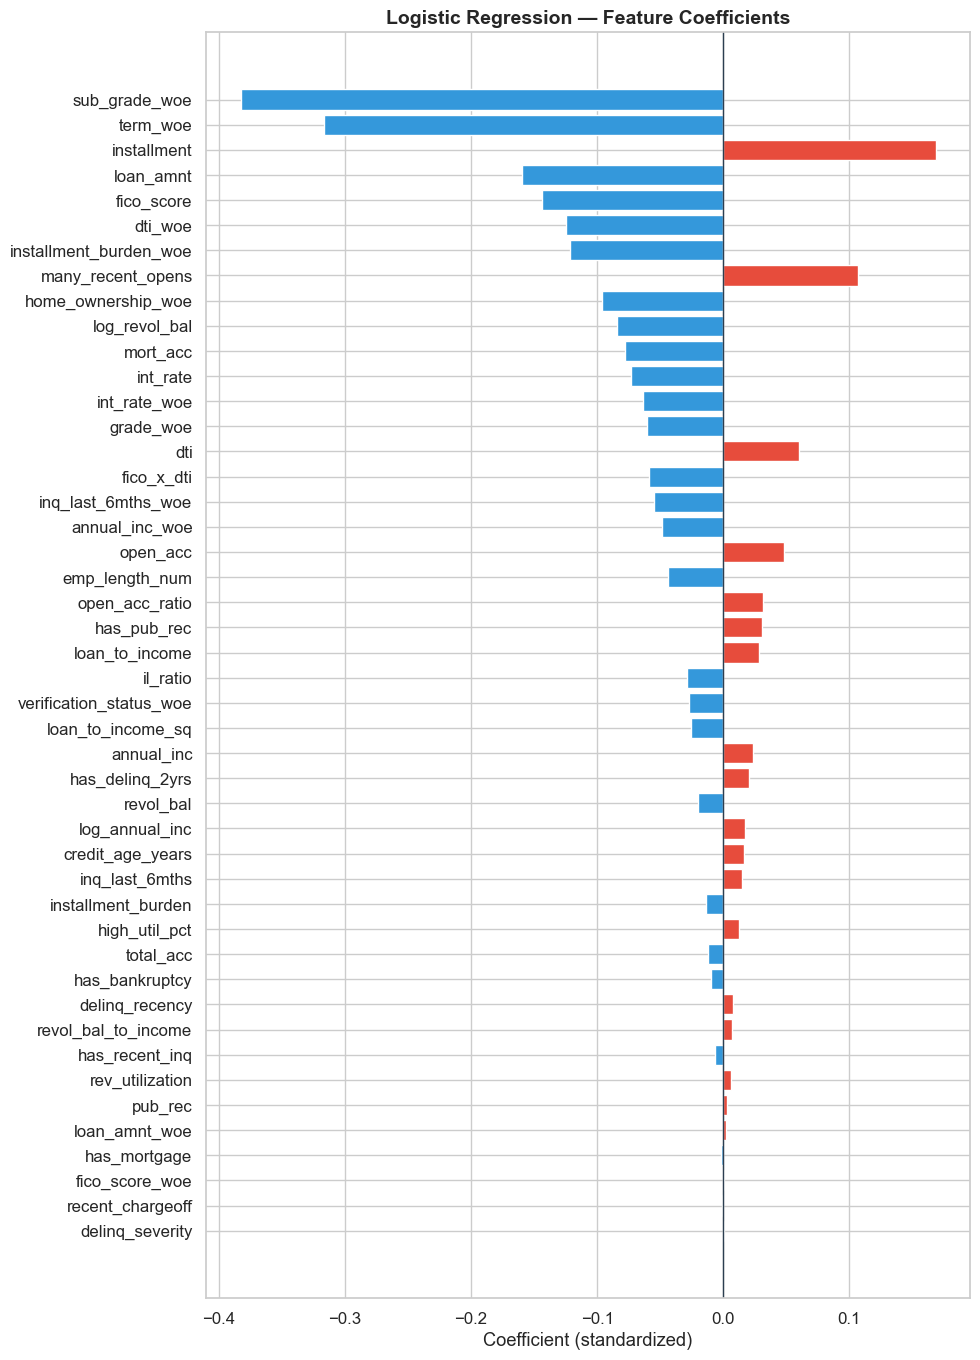

In [5]:
# LogReg coefficients
coef_df = pd.DataFrame({
    "feature": LOGREG_FEATURES,
    "coefficient": lr_pipeline.named_steps["clf"].coef_[0],
}).assign(abs_coef=lambda x: x["coefficient"].abs())
coef_df = coef_df.sort_values("abs_coef", ascending=False)

fig, ax = plt.subplots(figsize=(10, max(6, len(coef_df) * 0.3)))
colors = ["#e74c3c" if c > 0 else "#3498db" for c in coef_df["coefficient"]]
ax.barh(coef_df["feature"][::-1], coef_df["coefficient"][::-1], color=colors[::-1])
ax.axvline(0, color="#2c3e50", linewidth=1)
ax.set_xlabel("Coefficient (standardized)")
ax.set_title("Logistic Regression — Feature Coefficients", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

---
## 3. CatBoost — Default Configuration

Train CatBoost with sensible defaults before hyperparameter tuning.

In [6]:
# CatBoost default model
cb_params_default = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "l2_leaf_reg": 3,
    "auto_class_weights": "Balanced",
    "eval_metric": "Logloss",
    "random_seed": 42,
    "verbose": 200,
    "early_stopping_rounds": 50,
}

train_pool = Pool(X_train, y_train, cat_features=CAT_FEATURES)
cal_pool = Pool(X_cal, y_cal, cat_features=CAT_FEATURES)
test_pool = Pool(X_test, y_test, cat_features=CAT_FEATURES)

t0 = time.time()
cb_default = CatBoostClassifier(**cb_params_default)
cb_default.fit(train_pool, eval_set=cal_pool, use_best_model=True)
cb_train_time = time.time() - t0

# Predict
y_prob_cb = cb_default.predict_proba(X_test)[:, 1]

# Metrics
cb_metrics = classification_metrics(y_test.values, y_prob_cb)
cb_metrics["train_time_s"] = cb_train_time
cb_metrics["best_iteration"] = cb_default.get_best_iteration()

print(f"\nCatBoost Default Results (Test Set):")
print(f"  AUC-ROC:        {cb_metrics['auc_roc']:.4f}")
print(f"  Gini:           {cb_metrics['gini']:.4f}")
print(f"  KS:             {cb_metrics['ks_statistic']:.4f}")
print(f"  Brier:          {cb_metrics['brier_score']:.4f}")
print(f"  ECE:            {cb_metrics['ece']:.4f}")
print(f"  Best iteration: {cb_metrics['best_iteration']}")
print(f"  Train time:     {cb_train_time:.1f}s")

0:	learn: 0.6868675	test: 0.6869973	best: 0.6869973 (0)	total: 1.12s	remaining: 18m 38s
200:	learn: 0.6170383	test: 0.6211587	best: 0.6210911 (192)	total: 2m 48s	remaining: 11m 10s
400:	learn: 0.6135953	test: 0.6188351	best: 0.6188268 (399)	total: 5m 35s	remaining: 8m 20s
600:	learn: 0.6112641	test: 0.6180018	best: 0.6180018 (600)	total: 8m 11s	remaining: 5m 26s
800:	learn: 0.6094702	test: 0.6175508	best: 0.6175446 (789)	total: 10m 45s	remaining: 2m 40s
999:	learn: 0.6079471	test: 0.6172640	best: 0.6172634 (998)	total: 13m 21s	remaining: 0us

bestTest = 0.6172634129
bestIteration = 998

Shrink model to first 999 iterations.

CatBoost Default Results (Test Set):
  AUC-ROC:        0.7185
  Gini:           0.4369
  KS:             0.3218
  Brier:          0.1996
  ECE:            0.2040
  Best iteration: 998
  Train time:     802.3s


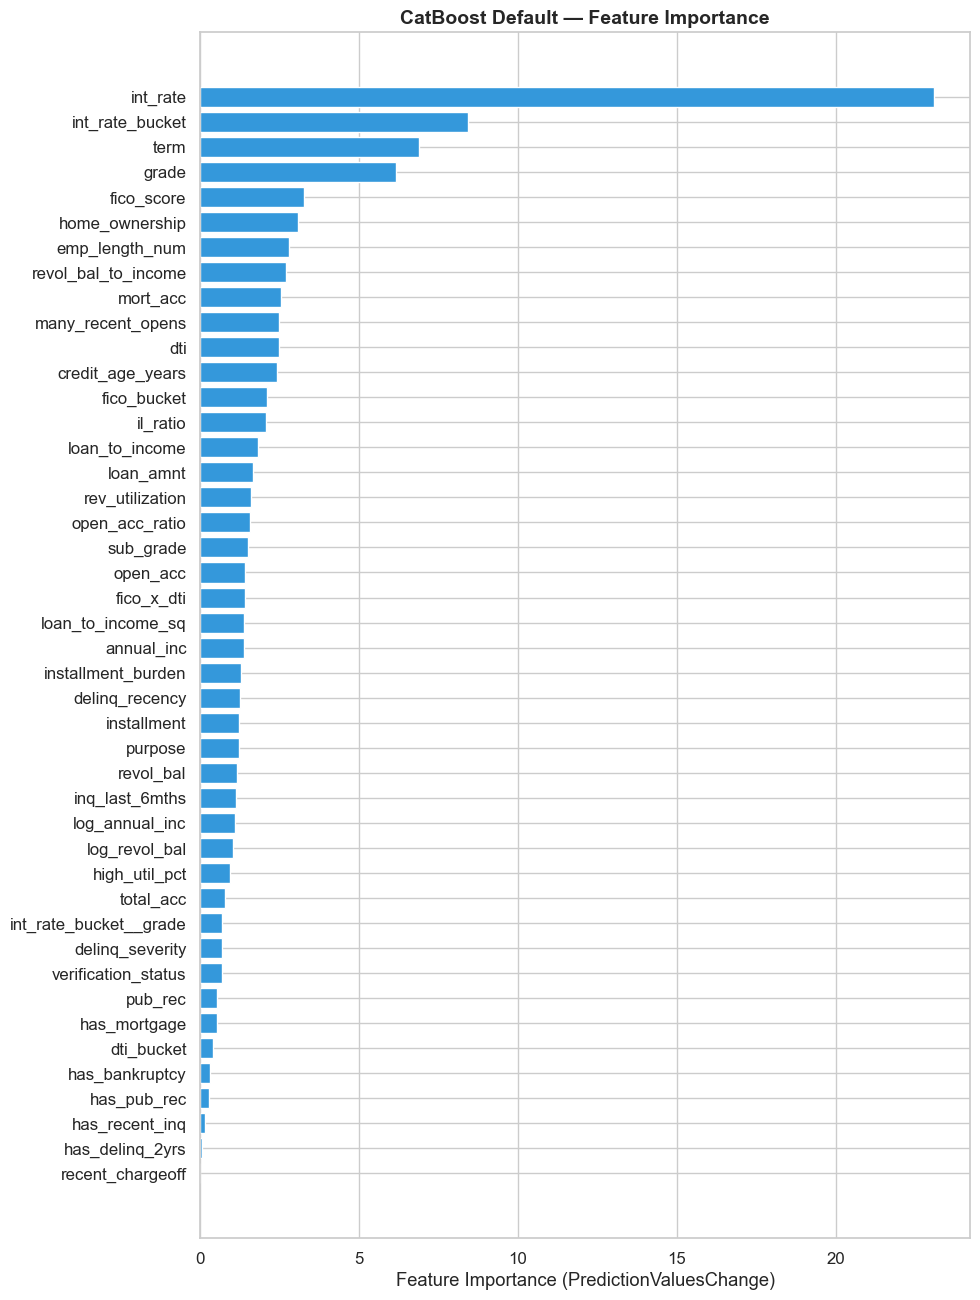


Top 10 features:
            feature  importance
           int_rate   23.088315
    int_rate_bucket    8.424205
               term    6.884043
              grade    6.156267
         fico_score    3.280873
     home_ownership    3.083943
     emp_length_num    2.811950
revol_bal_to_income    2.692328
           mort_acc    2.554872
  many_recent_opens    2.486010


In [7]:
# CatBoost built-in feature importance
fi = cb_default.get_feature_importance(type="PredictionValuesChange")
fi_df = pd.DataFrame({
    "feature": CATBOOST_FEATURES,
    "importance": fi
}).sort_values("importance", ascending=False)

fig, ax = plt.subplots(figsize=(10, max(6, len(fi_df) * 0.3)))
bars = ax.barh(fi_df["feature"][::-1], fi_df["importance"][::-1], color="#3498db")
ax.set_xlabel("Feature Importance (PredictionValuesChange)")
ax.set_title("CatBoost Default — Feature Importance", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

print("\nTop 10 features:")
print(fi_df.head(10).to_string(index=False))

---
## 4. Optuna Hyperparameter Optimization

Search over CatBoost hyperparameters using the calibration set as validation.
**30 trials** with early stopping and Optuna's TPE sampler for efficient exploration.

CatBoost bootstrap rules:
- `Bayesian` bootstrap → uses `bagging_temperature` (no `subsample`)
- `Bernoulli`/`MVS` bootstrap → uses `subsample` (no `bagging_temperature`)

We handle this with **conditional hyperparameters** in the Optuna objective.

In [8]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    # Bootstrap type determines which sampling params are valid
    bootstrap_type = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])

    params = {
        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "border_count": trial.suggest_int("border_count", 32, 128),
        "bootstrap_type": bootstrap_type,
        "auto_class_weights": "Balanced",
        "eval_metric": "Logloss",
        "random_seed": 42,
        "verbose": 0,
        "early_stopping_rounds": 30,
    }

    # Conditional params based on bootstrap type
    if bootstrap_type == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 5.0)
    else:
        params["subsample"] = trial.suggest_float("subsample", 0.6, 1.0)

    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=cal_pool, use_best_model=True)
    y_prob = model.predict_proba(X_cal)[:, 1]
    return roc_auc_score(y_cal, y_prob)

print("Starting Optuna HPO (30 trials, CPU)...")
t0 = time.time()
study = optuna.create_study(direction="maximize", study_name="pd_catboost")
study.optimize(objective, n_trials=30, show_progress_bar=True)
hpo_time = time.time() - t0

print(f"\nOptuna completed in {hpo_time/60:.1f} min")
print(f"Best AUC (validation): {study.best_value:.4f}")
print(f"Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

Starting Optuna HPO (30 trials, CPU)...


  0%|          | 0/30 [00:00<?, ?it/s]


Optuna completed in 138.7 min
Best AUC (validation): 0.7201
Best params:
  bootstrap_type: MVS
  learning_rate: 0.17935925189876642
  depth: 5
  l2_leaf_reg: 8.752154073914545
  min_data_in_leaf: 66
  border_count: 34
  subsample: 0.9186644171932347


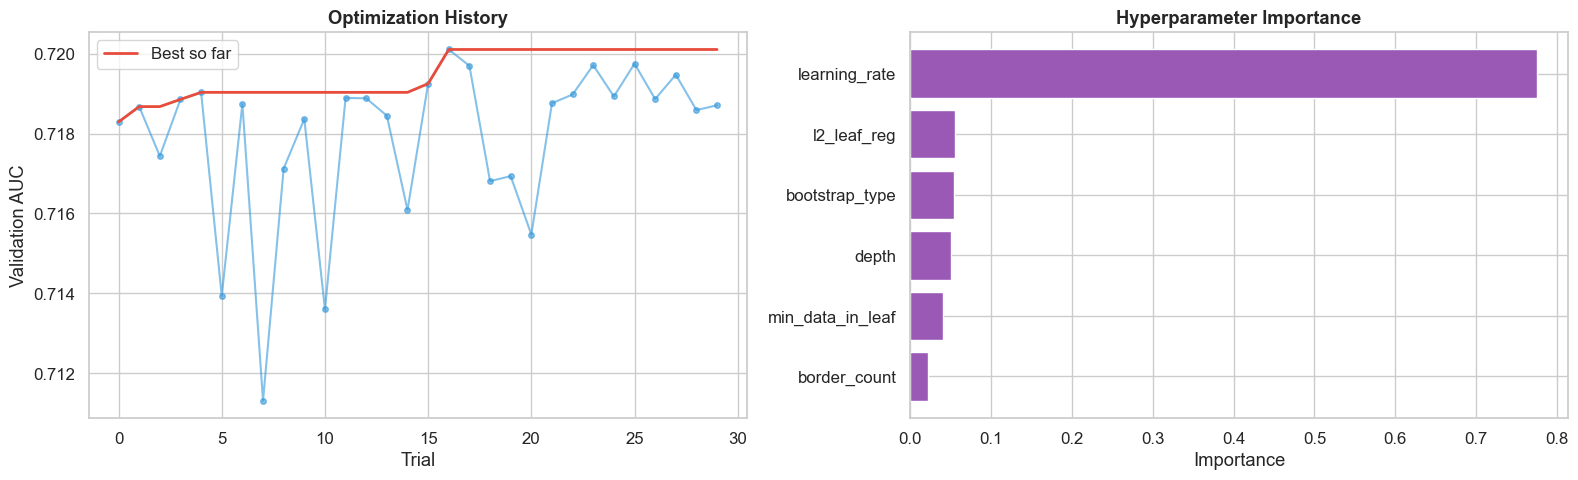

In [9]:
# Optuna optimization history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Trial values
trial_values = [t.value for t in study.trials if t.value is not None]
axes[0].plot(range(len(trial_values)), trial_values, "o-", alpha=0.6, markersize=4, color="#3498db")
best_so_far = pd.Series(trial_values).cummax()
axes[0].plot(range(len(best_so_far)), best_so_far, "-", color="#e74c3c", linewidth=2, label="Best so far")
axes[0].set_xlabel("Trial")
axes[0].set_ylabel("Validation AUC")
axes[0].set_title("Optimization History", fontweight="bold")
axes[0].legend()

# Parameter importance
try:
    param_imp = optuna.importance.get_param_importances(study)
    axes[1].barh(list(param_imp.keys())[::-1], list(param_imp.values())[::-1], color="#9b59b6")
    axes[1].set_xlabel("Importance")
    axes[1].set_title("Hyperparameter Importance", fontweight="bold")
except Exception:
    axes[1].text(0.5, 0.5, "Parameter importance\nnot available", ha="center", va="center", fontsize=12)
    axes[1].set_title("Hyperparameter Importance", fontweight="bold")

plt.tight_layout()
plt.show()

In [10]:
# Train final model with best params (CPU, more iterations)
best_params = study.best_params.copy()
best_params.update({
    "iterations": 2000,
    "auto_class_weights": "Balanced",
    "eval_metric": "Logloss",
    "random_seed": 42,
    "verbose": 200,
    "early_stopping_rounds": 100,
})

t0 = time.time()
cb_best = CatBoostClassifier(**best_params)
cb_best.fit(train_pool, eval_set=cal_pool, use_best_model=True)
cb_best_time = time.time() - t0

# Predict on test
y_prob_cb_best = cb_best.predict_proba(X_test)[:, 1]

# Metrics
cb_best_metrics = classification_metrics(y_test.values, y_prob_cb_best)
cb_best_metrics["train_time_s"] = cb_best_time
cb_best_metrics["best_iteration"] = cb_best.get_best_iteration()

print(f"CatBoost Tuned Results (Test Set):")
print(f"  AUC-ROC:        {cb_best_metrics['auc_roc']:.4f}")
print(f"  Gini:           {cb_best_metrics['gini']:.4f}")
print(f"  KS:             {cb_best_metrics['ks_statistic']:.4f}")
print(f"  Brier:          {cb_best_metrics['brier_score']:.4f}")
print(f"  ECE:            {cb_best_metrics['ece']:.4f}")
print(f"  Best iteration: {cb_best_metrics['best_iteration']}")
print(f"  Train time:     {cb_best_time:.1f}s")

# Improvement over default
delta_auc = cb_best_metrics["auc_roc"] - cb_metrics["auc_roc"]
print(f"\n  AUC improvement: {delta_auc:+.4f} ({delta_auc/cb_metrics['auc_roc']*100:+.2f}%)")

0:	learn: 0.6732962	test: 0.6738094	best: 0.6738094 (0)	total: 790ms	remaining: 26m 18s
200:	learn: 0.6127609	test: 0.6178944	best: 0.6178944 (200)	total: 2m 12s	remaining: 19m 45s
400:	learn: 0.6094950	test: 0.6170948	best: 0.6170593 (390)	total: 4m 27s	remaining: 17m 45s
600:	learn: 0.6070788	test: 0.6169275	best: 0.6169001 (596)	total: 6m 39s	remaining: 15m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6168807844
bestIteration = 619

Shrink model to first 620 iterations.
CatBoost Tuned Results (Test Set):
  AUC-ROC:        0.7187
  Gini:           0.4373
  KS:             0.3221
  Brier:          0.1986
  ECE:            0.2014
  Best iteration: 619
  Train time:     481.9s

  AUC improvement: +0.0002 (+0.03%)


---
## 5. SHAP Explainability

Global and local feature importance using SHAP values. CatBoost has native SHAP support via `get_feature_importance(type='ShapValues')`.

In [11]:
import shap

# Compute SHAP values using CatBoost's native method
# Use a sample for performance (SHAP on 1.3M rows is slow)
shap_sample_size = min(10_000, len(X_test))
X_shap = X_test.sample(shap_sample_size, random_state=42)
shap_pool = Pool(X_shap, cat_features=CAT_FEATURES)

t0 = time.time()
shap_values_raw = cb_best.get_feature_importance(
    type="ShapValues", data=shap_pool
)
shap_time = time.time() - t0

# CatBoost ShapValues returns (n_samples, n_features+1) — last col is base value
shap_values = shap_values_raw[:, :-1]
base_value = shap_values_raw[0, -1]

print(f"SHAP computed on {shap_sample_size:,} samples in {shap_time:.1f}s")
print(f"SHAP values shape: {shap_values.shape}")
print(f"Base value (log-odds): {base_value:.4f}")

SHAP computed on 10,000 samples in 0.4s
SHAP values shape: (10000, 44)
Base value (log-odds): -0.2405


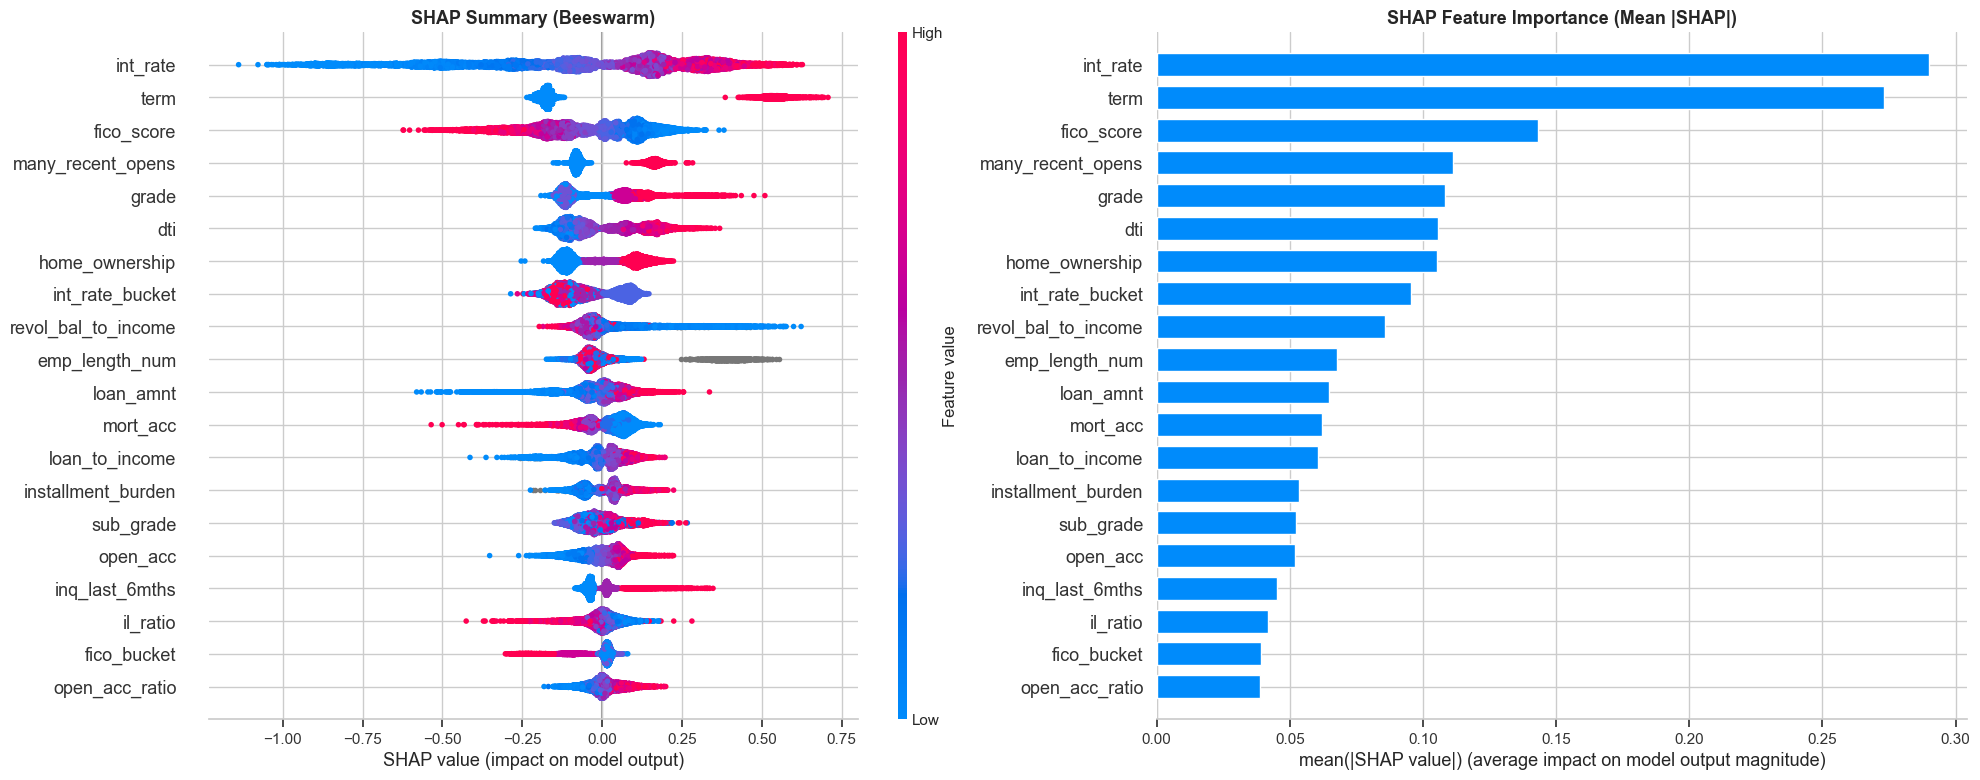

In [12]:
# SHAP Summary Plot (beeswarm)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Beeswarm — need to handle categoricals by converting to numeric for display
X_shap_numeric = X_shap.copy()
for c in CAT_FEATURES:
    if c in X_shap_numeric.columns:
        X_shap_numeric[c] = pd.Categorical(X_shap_numeric[c]).codes

plt.sca(axes[0])
shap.summary_plot(shap_values, X_shap_numeric, feature_names=CATBOOST_FEATURES,
                  show=False, max_display=20, plot_size=None)
axes[0].set_title("SHAP Summary (Beeswarm)", fontweight="bold", fontsize=13)

# Bar plot — mean |SHAP|
plt.sca(axes[1])
shap.summary_plot(shap_values, X_shap_numeric, feature_names=CATBOOST_FEATURES,
                  plot_type="bar", show=False, max_display=20, plot_size=None)
axes[1].set_title("SHAP Feature Importance (Mean |SHAP|)", fontweight="bold", fontsize=13)

plt.tight_layout()
plt.show()

C:\Users\carlos\AppData\Local\Temp\ipykernel_23480\2577674117.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot([cat_shap[c] for c in unique_cats], labels=unique_cats)


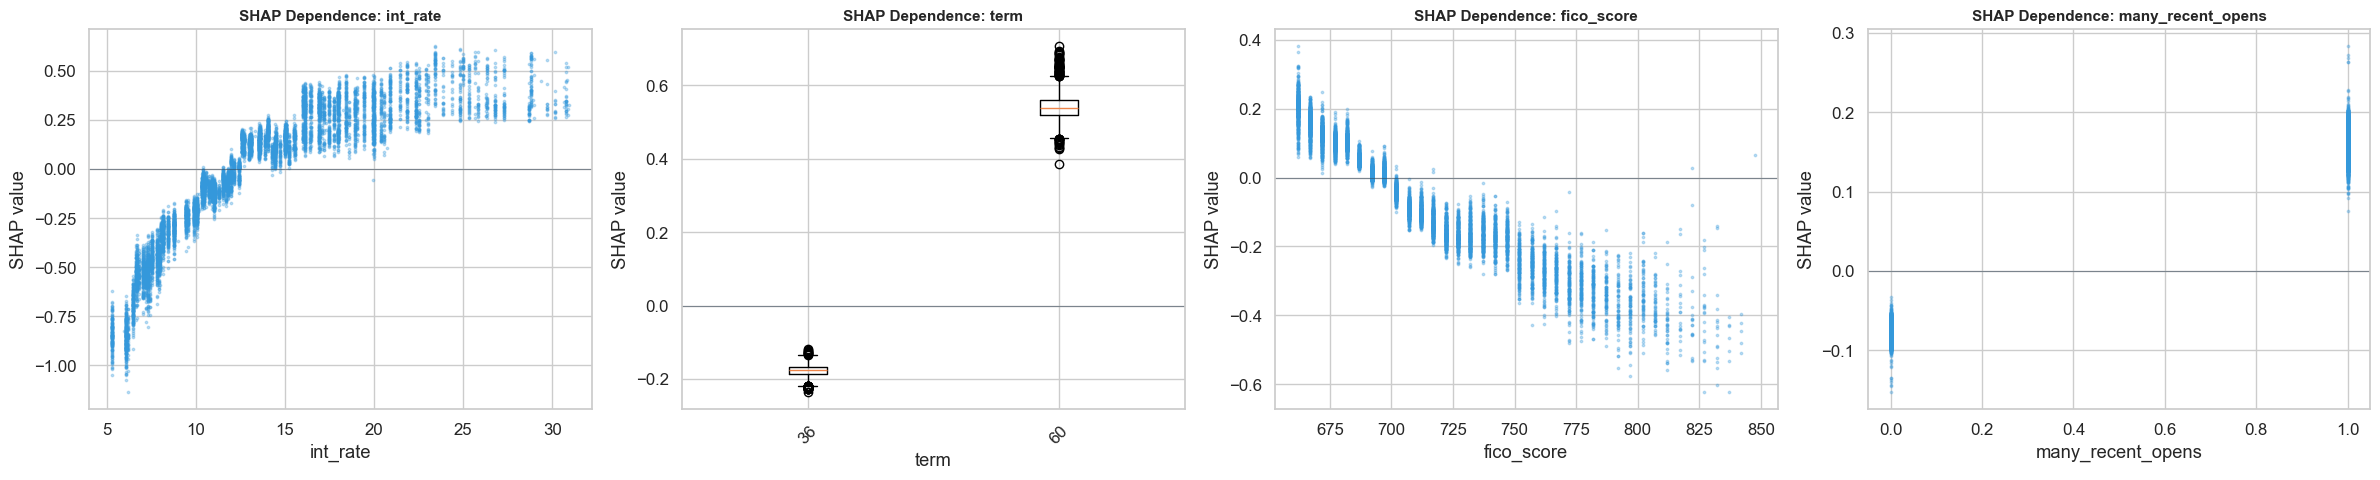

In [13]:
# SHAP Dependence plots for top 4 features
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(mean_abs_shap)[::-1][:4]
top_feature_names = [CATBOOST_FEATURES[i] for i in top_features_idx]

fig, axes = plt.subplots(1, 4, figsize=(24, 5))
for idx, (feat_idx, feat_name) in enumerate(zip(top_features_idx, top_feature_names)):
    if feat_name in CAT_FEATURES:
        # For categorical: box plot of SHAP by category
        categories = X_shap[feat_name].values
        unique_cats = sorted(set(categories))[:10]  # limit to 10
        cat_shap = {c: shap_values[categories == c, feat_idx] for c in unique_cats}
        axes[idx].boxplot([cat_shap[c] for c in unique_cats], labels=unique_cats)
        axes[idx].set_xlabel(feat_name)
        axes[idx].set_ylabel("SHAP value")
        axes[idx].tick_params(axis="x", rotation=45)
    else:
        # For numeric: scatter
        axes[idx].scatter(
            X_shap_numeric[feat_name].values, shap_values[:, feat_idx],
            alpha=0.3, s=3, color="#3498db"
        )
        axes[idx].set_xlabel(feat_name)
        axes[idx].set_ylabel("SHAP value")
    axes[idx].axhline(0, color="#2c3e50", linewidth=0.8, alpha=0.5)
    axes[idx].set_title(f"SHAP Dependence: {feat_name}", fontweight="bold", fontsize=11)

plt.tight_layout()
plt.show()

---
## 6. Model Comparison — ROC & Precision-Recall

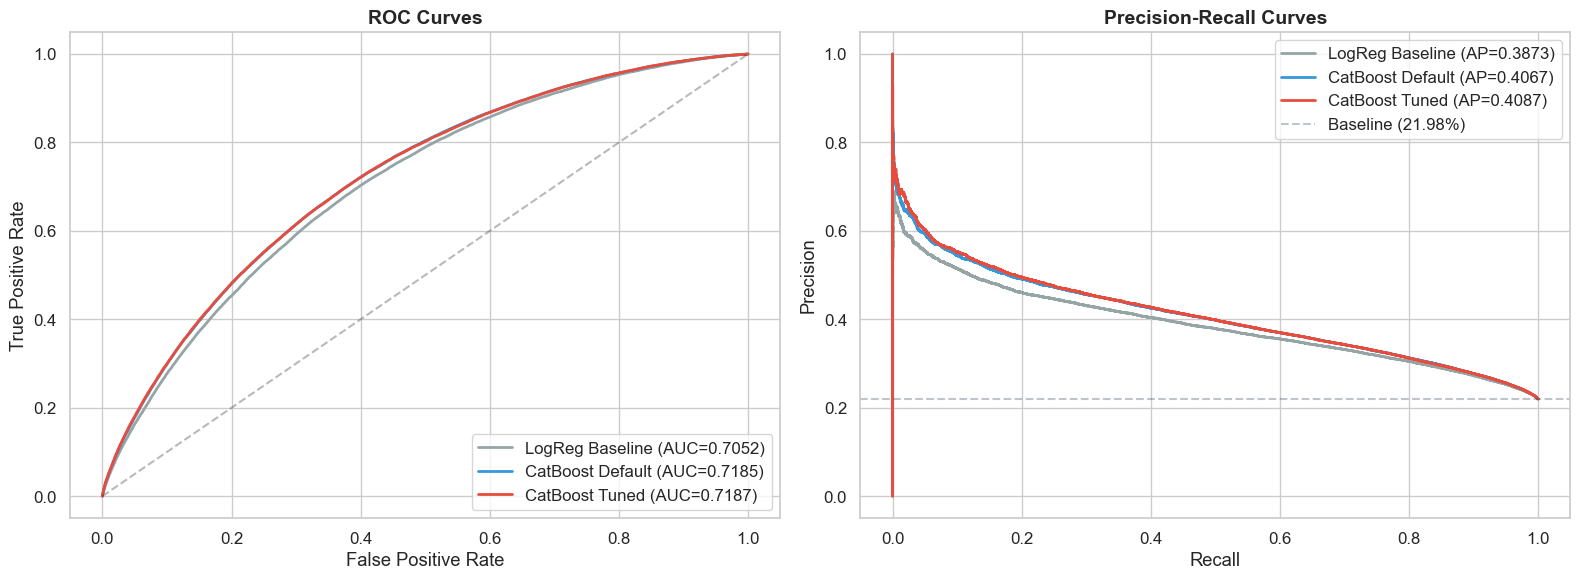

In [14]:
# ROC curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models = {
    "LogReg Baseline": y_prob_lr,
    "CatBoost Default": y_prob_cb,
    "CatBoost Tuned": y_prob_cb_best,
}
colors_model = ["#95a5a6", "#3498db", "#e74c3c"]

# ROC
for (name, y_prob), color in zip(models.items(), colors_model):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    axes[0].plot(fpr, tpr, color=color, linewidth=2, label=f"{name} (AUC={auc:.4f})")

axes[0].plot([0, 1], [0, 1], "k--", alpha=0.3)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curves", fontweight="bold", fontsize=14)
axes[0].legend(loc="lower right")

# Precision-Recall
for (name, y_prob), color in zip(models.items(), colors_model):
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    axes[1].plot(rec, prec, color=color, linewidth=2, label=f"{name} (AP={ap:.4f})")

axes[1].axhline(y_test.mean(), color="#2c3e50", ls="--", alpha=0.3, label=f"Baseline ({y_test.mean():.2%})")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curves", fontweight="bold", fontsize=14)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

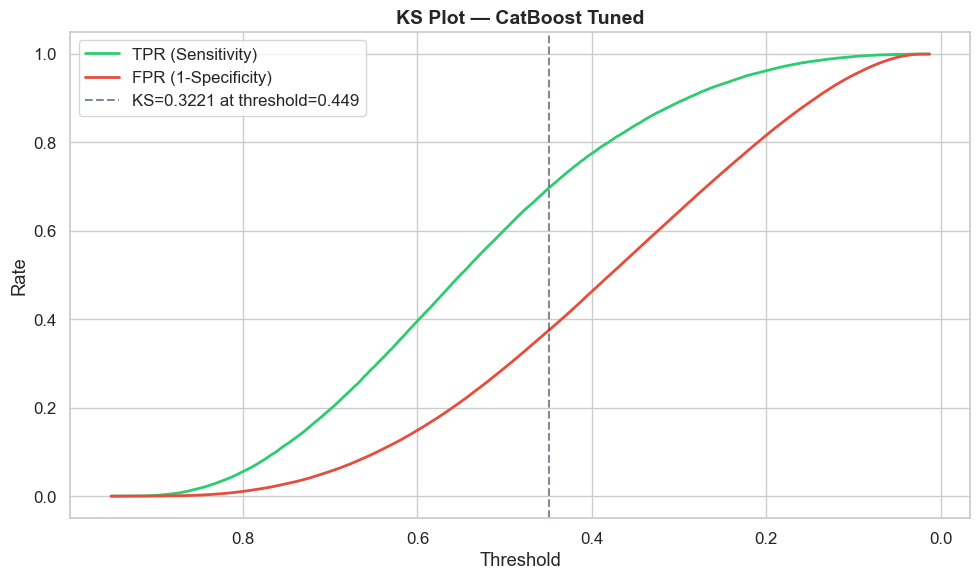

KS Statistic: 0.3221 at threshold 0.449


In [15]:
# KS Plot for best model
fpr, tpr, thresholds = roc_curve(y_test, y_prob_cb_best)
ks_values = tpr - fpr
ks_max_idx = np.argmax(ks_values)
ks_max = ks_values[ks_max_idx]
ks_threshold = thresholds[ks_max_idx]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, tpr[:-1] if len(tpr) > len(thresholds) else tpr[:len(thresholds)],
        label="TPR (Sensitivity)", color="#2ecc71", linewidth=2)
ax.plot(thresholds, fpr[:-1] if len(fpr) > len(thresholds) else fpr[:len(thresholds)],
        label="FPR (1-Specificity)", color="#e74c3c", linewidth=2)
ax.axvline(ks_threshold, color="#2c3e50", ls="--", alpha=0.6,
           label=f"KS={ks_max:.4f} at threshold={ks_threshold:.3f}")
ax.set_xlabel("Threshold")
ax.set_ylabel("Rate")
ax.set_title("KS Plot — CatBoost Tuned", fontweight="bold", fontsize=14)
ax.legend()
ax.invert_xaxis()
plt.tight_layout()
plt.show()

print(f"KS Statistic: {ks_max:.4f} at threshold {ks_threshold:.3f}")

---
## 7. Probability Calibration

CatBoost is typically well-calibrated, but we test Isotonic and Platt to verify.

Legacy results: Uncalibrated ECE=0.0029, Isotonic ECE=0.0019, Platt ECE=0.0187.

In [16]:
# Calibration using the calibration set
y_prob_cal = cb_best.predict_proba(X_cal)[:, 1]

# Isotonic calibration
from sklearn.isotonic import IsotonicRegression
iso_cal = IsotonicRegression(y_min=0, y_max=1, out_of_bounds="clip")
iso_cal.fit(y_prob_cal, y_cal.values)
y_prob_iso = iso_cal.predict(y_prob_cb_best)

# Platt scaling
from sklearn.linear_model import LogisticRegression as PlattLR
platt_lr = PlattLR(max_iter=1000)
platt_lr.fit(y_prob_cal.reshape(-1, 1), y_cal.values)
y_prob_platt = platt_lr.predict_proba(y_prob_cb_best.reshape(-1, 1))[:, 1]

# Compute metrics for all calibration methods
cal_results = {}
for name, y_prob in [("Uncalibrated", y_prob_cb_best),
                      ("Isotonic", y_prob_iso),
                      ("Platt Sigmoid", y_prob_platt)]:
    ece = expected_calibration_error(y_test.values, y_prob)
    brier = brier_score_loss(y_test.values, y_prob)
    auc = roc_auc_score(y_test.values, y_prob)
    cal_results[name] = {"ECE": ece, "Brier": brier, "AUC": auc}
    print(f"{name:20s} — ECE: {ece:.4f}, Brier: {brier:.4f}, AUC: {auc:.4f}")

cal_results_df = pd.DataFrame(cal_results).T
print("\n" + cal_results_df.to_string())

Uncalibrated         — ECE: 0.2014, Brier: 0.1986, AUC: 0.7187
Isotonic             — ECE: 0.0129, Brier: 0.1537, AUC: 0.7185
Platt Sigmoid        — ECE: 0.0128, Brier: 0.1537, AUC: 0.7187

                    ECE     Brier       AUC
Uncalibrated   0.201382  0.198565  0.718669
Isotonic       0.012938  0.153739  0.718461
Platt Sigmoid  0.012795  0.153747  0.718669


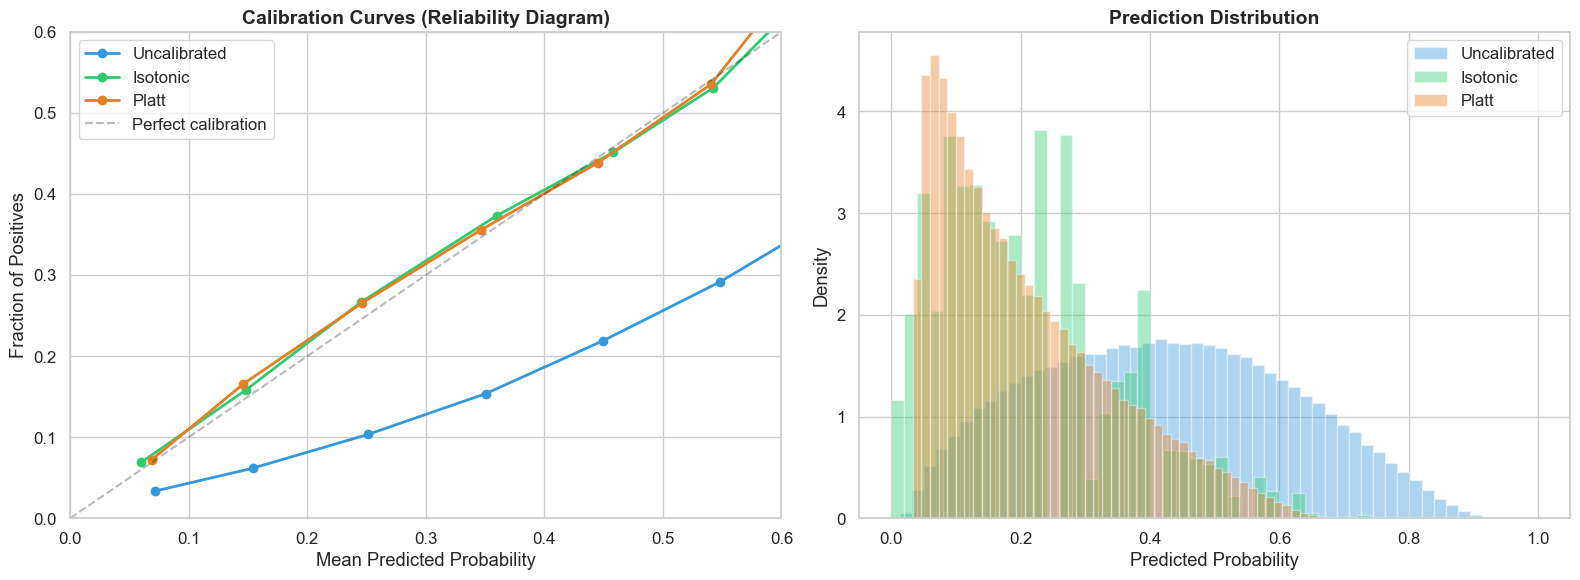

In [17]:
# Calibration curves (reliability diagrams)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cal_data = [
    ("Uncalibrated", y_prob_cb_best, "#3498db"),
    ("Isotonic", y_prob_iso, "#2ecc71"),
    ("Platt", y_prob_platt, "#e67e22"),
]

for name, y_prob, color in cal_data:
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="uniform")
    axes[0].plot(prob_pred, prob_true, "o-", color=color, linewidth=2, markersize=6, label=name)

axes[0].plot([0, 1], [0, 1], "k--", alpha=0.3, label="Perfect calibration")
axes[0].set_xlabel("Mean Predicted Probability")
axes[0].set_ylabel("Fraction of Positives")
axes[0].set_title("Calibration Curves (Reliability Diagram)", fontweight="bold", fontsize=14)
axes[0].legend()
axes[0].set_xlim([0, 0.6])
axes[0].set_ylim([0, 0.6])

# Prediction distribution by calibration method
for name, y_prob, color in cal_data:
    axes[1].hist(y_prob, bins=50, alpha=0.4, color=color, label=name, density=True)

axes[1].set_xlabel("Predicted Probability")
axes[1].set_ylabel("Density")
axes[1].set_title("Prediction Distribution", fontweight="bold", fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.show()

In [18]:
# Select best calibration method
best_cal_name = min(cal_results, key=lambda k: cal_results[k]["ECE"])
print(f"Best calibration: {best_cal_name} (ECE={cal_results[best_cal_name]['ECE']:.4f})")

if best_cal_name == "Isotonic":
    y_prob_final = y_prob_iso
    calibrator = iso_cal
elif best_cal_name == "Platt Sigmoid":
    y_prob_final = y_prob_platt
    calibrator = platt_lr
else:
    y_prob_final = y_prob_cb_best
    calibrator = None

print(f"\nFinal model: CatBoost Tuned + {best_cal_name}")

Best calibration: Platt Sigmoid (ECE=0.0128)

Final model: CatBoost Tuned + Platt Sigmoid


---
## 8. Final Evaluation — Complete Metrics Report

In [19]:
# Full metrics comparison table
final_metrics = classification_metrics(y_test.values, y_prob_final)

results_table = pd.DataFrame({
    "LogReg Baseline": {
        "AUC-ROC": lr_metrics["auc_roc"],
        "Gini": lr_metrics["gini"],
        "KS": lr_metrics["ks_statistic"],
        "Brier": lr_metrics["brier_score"],
        "ECE": lr_metrics["ece"],
    },
    "CatBoost Default": {
        "AUC-ROC": cb_metrics["auc_roc"],
        "Gini": cb_metrics["gini"],
        "KS": cb_metrics["ks_statistic"],
        "Brier": cb_metrics["brier_score"],
        "ECE": cb_metrics["ece"],
    },
    "CatBoost Tuned": {
        "AUC-ROC": cb_best_metrics["auc_roc"],
        "Gini": cb_best_metrics["gini"],
        "KS": cb_best_metrics["ks_statistic"],
        "Brier": cb_best_metrics["brier_score"],
        "ECE": cb_best_metrics["ece"],
    },
    f"CatBoost + {best_cal_name}": {
        "AUC-ROC": final_metrics["auc_roc"],
        "Gini": final_metrics["gini"],
        "KS": final_metrics["ks_statistic"],
        "Brier": final_metrics["brier_score"],
        "ECE": final_metrics["ece"],
    },
})

# Format and display
print("=" * 80)
print("FINAL MODEL COMPARISON — TEST SET (Out-of-Time)")
print("=" * 80)
print(results_table.T.to_string(float_format="{:.4f}".format))
print()

# Highlight best
for metric in results_table.index:
    best_col = results_table.loc[metric].idxmax() if metric in ["AUC-ROC", "Gini", "KS"] else results_table.loc[metric].idxmin()
    best_val = results_table.loc[metric, best_col]
    print(f"  Best {metric:8s}: {best_val:.4f} ({best_col})")

FINAL MODEL COMPARISON — TEST SET (Out-of-Time)
                          AUC-ROC   Gini     KS  Brier    ECE
LogReg Baseline            0.7052 0.4104 0.3030 0.2016 0.2045
CatBoost Default           0.7185 0.4369 0.3218 0.1996 0.2040
CatBoost Tuned             0.7187 0.4373 0.3221 0.1986 0.2014
CatBoost + Platt Sigmoid   0.7187 0.4373 0.3221 0.1537 0.0128

  Best AUC-ROC : 0.7187 (CatBoost Tuned)
  Best Gini    : 0.4373 (CatBoost Tuned)
  Best KS      : 0.3221 (CatBoost Tuned)
  Best Brier   : 0.1537 (CatBoost + Platt Sigmoid)
  Best ECE     : 0.0128 (CatBoost + Platt Sigmoid)


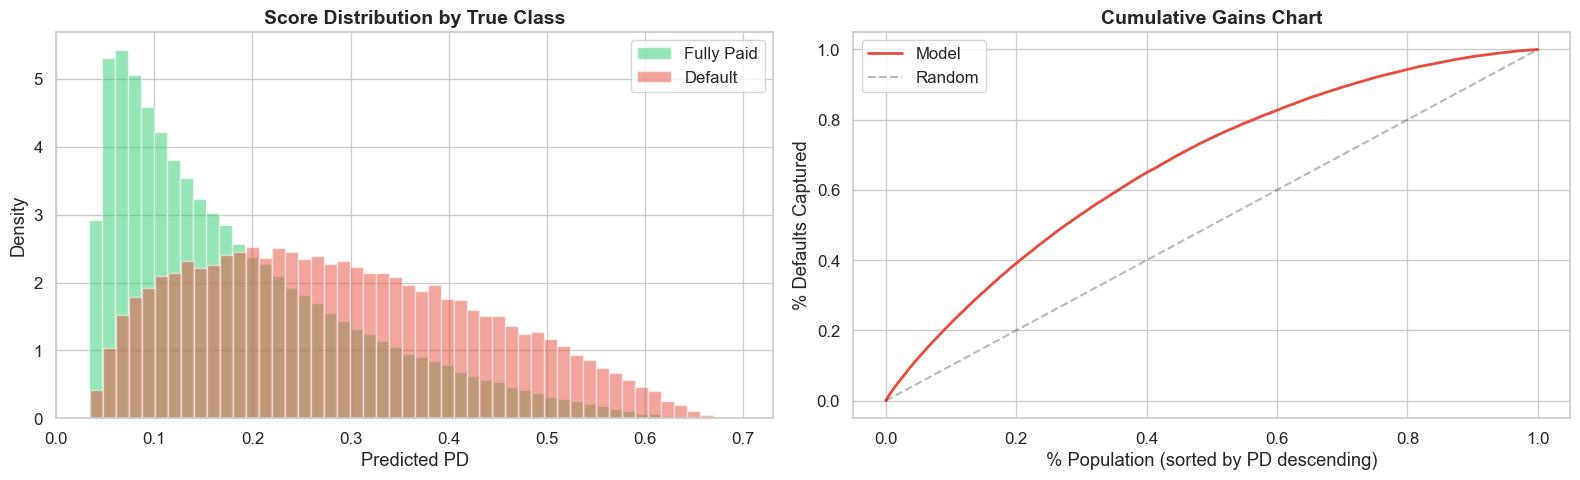

In [20]:
# Score distribution by true class — final model
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
for flag in [0, 1]:
    mask = y_test == flag
    label = "Fully Paid" if flag == 0 else "Default"
    color = "#2ecc71" if flag == 0 else "#e74c3c"
    axes[0].hist(y_prob_final[mask], bins=50, alpha=0.5, density=True,
                 color=color, label=label)
axes[0].set_xlabel("Predicted PD")
axes[0].set_ylabel("Density")
axes[0].set_title("Score Distribution by True Class", fontweight="bold", fontsize=14)
axes[0].legend()

# Cumulative gains chart
sorted_idx = np.argsort(y_prob_final)[::-1]
y_sorted = y_test.values[sorted_idx]
cum_defaults = np.cumsum(y_sorted) / y_sorted.sum()
pct_population = np.arange(1, len(y_sorted) + 1) / len(y_sorted)

axes[1].plot(pct_population, cum_defaults, color="#e74c3c", linewidth=2, label="Model")
axes[1].plot([0, 1], [0, 1], "k--", alpha=0.3, label="Random")
axes[1].set_xlabel("% Population (sorted by PD descending)")
axes[1].set_ylabel("% Defaults Captured")
axes[1].set_title("Cumulative Gains Chart", fontweight="bold", fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 9. Decile Analysis & Lift Table

Rank-ordering analysis: divide the test portfolio into 10 equal bins by predicted PD. A well-performing model should show monotonically increasing default rates across deciles, with high lift in the riskiest segments.

DECILE ANALYSIS — Test Set (Out-of-Time)
 decile  n_loans  n_defaults  default_rate  avg_pd  min_pd  max_pd   lift
      1    27687        1235        0.0446  0.0505  0.0331  0.0621 0.2030
      2    27687        2225        0.0804  0.0732  0.0621  0.0846 0.3657
      3    27687        3071        0.1109  0.0970  0.0846  0.1100 0.5047
      4    27687        3983        0.1439  0.1245  0.1100  0.1397 0.6546
      5    27687        4786        0.1729  0.1565  0.1397  0.1741 0.7865
      6    27686        6043        0.2183  0.1939  0.1741  0.2148 0.9931
      7    27687        7173        0.2591  0.2382  0.2148  0.2635 1.1788
      8    27687        8541        0.3085  0.2928  0.2635  0.3254 1.4036
      9    27687       10313        0.3725  0.3661  0.3254  0.4128 1.6948
     10    27687       13480        0.4869  0.4902  0.4128  0.6978 2.2153

Base default rate: 0.2198
Top decile lift: 2.22x
Top 3 deciles capture: 53.1% of all defaults


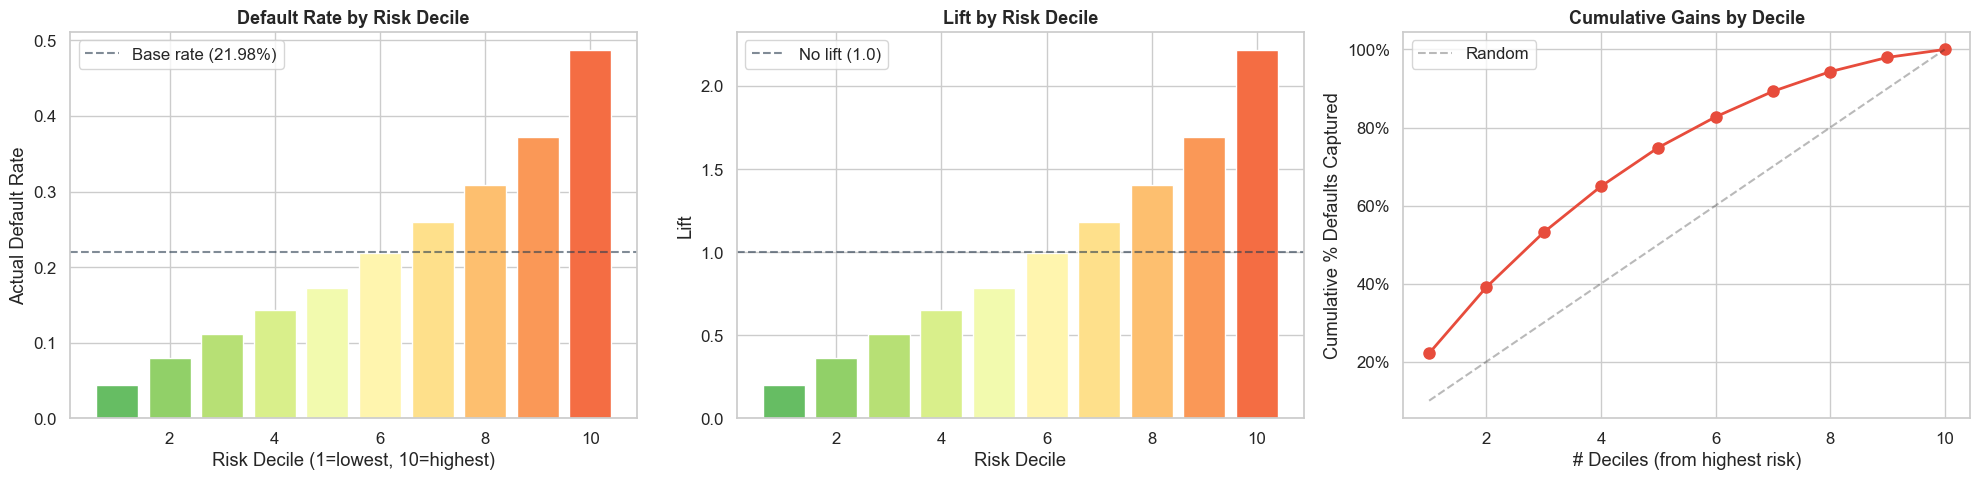

In [21]:
# Decile analysis on final calibrated predictions
decile_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_prob": y_prob_final,
})

# Create deciles (1=lowest risk, 10=highest risk)
decile_df["decile"] = pd.qcut(decile_df["y_prob"], q=10, labels=False, duplicates="drop") + 1

decile_stats = decile_df.groupby("decile").agg(
    n_loans=("y_true", "count"),
    n_defaults=("y_true", "sum"),
    default_rate=("y_true", "mean"),
    avg_pd=("y_prob", "mean"),
    min_pd=("y_prob", "min"),
    max_pd=("y_prob", "max"),
).reset_index()

base_rate = decile_df["y_true"].mean()
decile_stats["lift"] = decile_stats["default_rate"] / base_rate

# Cumulative capture from highest risk decile down
decile_rev = decile_stats.sort_values("decile", ascending=False).reset_index(drop=True)
decile_rev["cum_defaults"] = decile_rev["n_defaults"].cumsum()
decile_rev["cum_capture"] = decile_rev["cum_defaults"] / decile_rev["n_defaults"].sum()

print("=" * 95)
print("DECILE ANALYSIS — Test Set (Out-of-Time)")
print("=" * 95)
print(decile_stats.to_string(index=False, float_format="{:.4f}".format))
print(f"\nBase default rate: {base_rate:.4f}")
print(f"Top decile lift: {decile_stats.iloc[-1]['lift']:.2f}x")
top3_capture = decile_rev.iloc[:3]["cum_capture"].iloc[-1]
print(f"Top 3 deciles capture: {top3_capture:.1%} of all defaults")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
colors_d = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, 10))

# Default rate by decile
axes[0].bar(decile_stats["decile"], decile_stats["default_rate"], color=colors_d)
axes[0].axhline(base_rate, color="#2c3e50", ls="--", alpha=0.6,
                label=f"Base rate ({base_rate:.2%})")
axes[0].set_xlabel("Risk Decile (1=lowest, 10=highest)")
axes[0].set_ylabel("Actual Default Rate")
axes[0].set_title("Default Rate by Risk Decile", fontweight="bold", fontsize=13)
axes[0].legend()

# Lift chart
axes[1].bar(decile_stats["decile"], decile_stats["lift"], color=colors_d)
axes[1].axhline(1.0, color="#2c3e50", ls="--", alpha=0.6, label="No lift (1.0)")
axes[1].set_xlabel("Risk Decile")
axes[1].set_ylabel("Lift")
axes[1].set_title("Lift by Risk Decile", fontweight="bold", fontsize=13)
axes[1].legend()

# Cumulative gains
n_dec = range(1, len(decile_rev) + 1)
axes[2].plot(n_dec, decile_rev["cum_capture"].values, "o-",
             color="#e74c3c", linewidth=2, markersize=8)
axes[2].plot(n_dec, np.linspace(0.1, 1.0, len(decile_rev)),
             "k--", alpha=0.3, label="Random")
axes[2].set_xlabel("# Deciles (from highest risk)")
axes[2].set_ylabel("Cumulative % Defaults Captured")
axes[2].set_title("Cumulative Gains by Decile", fontweight="bold", fontsize=13)
axes[2].legend()
axes[2].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

---
## 10. Population Stability Index (PSI)

PSI quantifies distribution shift between training and OOT test sets — critical for model monitoring:
- **PSI < 0.10**: Stable — no action needed
- **0.10 ≤ PSI < 0.25**: Moderate shift — investigate
- **PSI ≥ 0.25**: Significant shift — model may need retraining

POPULATION STABILITY INDEX (Train vs Test — OOT)
            Feature    PSI      Status
    rev_utilization 0.2648 SIGNIFICANT
      high_util_pct 0.2539 SIGNIFICANT
         fico_score 0.1319    Moderate
           int_rate 0.0987      Stable
revol_bal_to_income 0.0717      Stable
          revol_bal 0.0546      Stable
      log_revol_bal 0.0546      Stable
  loan_to_income_sq 0.0499      Stable
     loan_to_income 0.0499      Stable
 installment_burden 0.0431      Stable
           il_ratio 0.0424      Stable
          loan_amnt 0.0385      Stable
         fico_x_dti 0.0309      Stable
     ** PD Score ** 0.0271      Stable
        installment 0.0259      Stable
                dti 0.0257      Stable
     delinq_recency 0.0257      Stable
          total_acc 0.0226      Stable
   credit_age_years 0.0210      Stable
     open_acc_ratio 0.0209      Stable
     inq_last_6mths 0.0140      Stable
           open_acc 0.0139      Stable
           mort_acc 0.0137      Stable
     log_annual

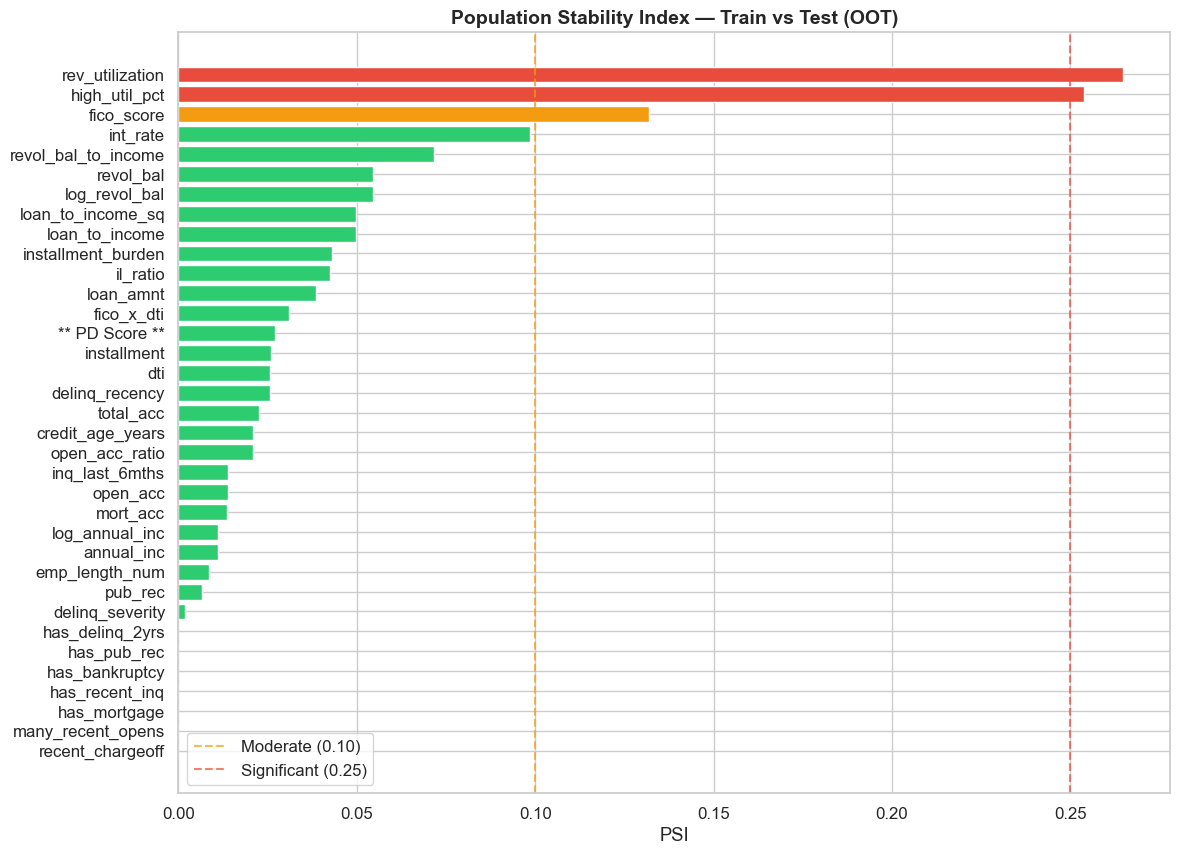

In [22]:
def calculate_psi(expected, actual, n_bins=10):
    """Population Stability Index between two distributions."""
    _, bin_edges = pd.qcut(expected, q=n_bins, retbins=True, duplicates="drop")
    bin_edges = bin_edges.copy()
    bin_edges[0] = -np.inf
    bin_edges[-1] = np.inf

    expected_counts = np.histogram(expected, bins=bin_edges)[0]
    actual_counts = np.histogram(actual, bins=bin_edges)[0]

    expected_pct = expected_counts / expected_counts.sum() + 1e-8
    actual_pct = actual_counts / actual_counts.sum() + 1e-8

    return np.sum((actual_pct - expected_pct) * np.log(actual_pct / expected_pct))

# PSI for key features (train vs OOT test)
numeric_feats_psi = [f for f in CATBOOST_FEATURES if f not in CAT_FEATURES]
psi_results = {}
for col in numeric_feats_psi:
    tr = X_train[col].dropna()
    te = X_test[col].dropna()
    if len(tr) > 100 and len(te) > 100:
        psi_results[col] = calculate_psi(tr.values, te.values)

# PSI for the PD score itself
train_sample_psi = X_train.sample(min(100_000, len(X_train)), random_state=42)
y_prob_train_psi = cb_best.predict_proba(train_sample_psi)[:, 1]
psi_results["** PD Score **"] = calculate_psi(y_prob_train_psi, y_prob_cb_best)

psi_df = pd.DataFrame({"Feature": psi_results.keys(), "PSI": psi_results.values()})
psi_df = psi_df.sort_values("PSI", ascending=False).reset_index(drop=True)
psi_df["Status"] = psi_df["PSI"].apply(
    lambda x: "SIGNIFICANT" if x >= 0.25 else ("Moderate" if x >= 0.10 else "Stable")
)

print("=" * 65)
print("POPULATION STABILITY INDEX (Train vs Test — OOT)")
print("=" * 65)
print(psi_df.to_string(index=False, float_format="{:.4f}".format))

n_sig = (psi_df["Status"] == "SIGNIFICANT").sum()
n_mod = (psi_df["Status"] == "Moderate").sum()
n_stab = len(psi_df) - n_sig - n_mod
print(f"\nSummary: {n_sig} significant, {n_mod} moderate, {n_stab} stable")

# Visualization
fig, ax = plt.subplots(figsize=(12, max(5, len(psi_df) * 0.25)))
colors_psi = ["#e74c3c" if s == "SIGNIFICANT" else "#f39c12" if s == "Moderate"
              else "#2ecc71" for s in psi_df["Status"]]
ax.barh(psi_df["Feature"][::-1], psi_df["PSI"][::-1], color=colors_psi[::-1])
ax.axvline(0.10, color="#f39c12", ls="--", alpha=0.7, label="Moderate (0.10)")
ax.axvline(0.25, color="#e74c3c", ls="--", alpha=0.7, label="Significant (0.25)")
ax.set_xlabel("PSI")
ax.set_title("Population Stability Index — Train vs Test (OOT)",
             fontweight="bold", fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

---
## 11. Partial Dependence Plots (PDP)

PDP shows the average marginal effect of each feature on predicted PD. Unlike SHAP (which decomposes individual predictions), PDP reveals the global functional form: linear, monotonic, or threshold effects.

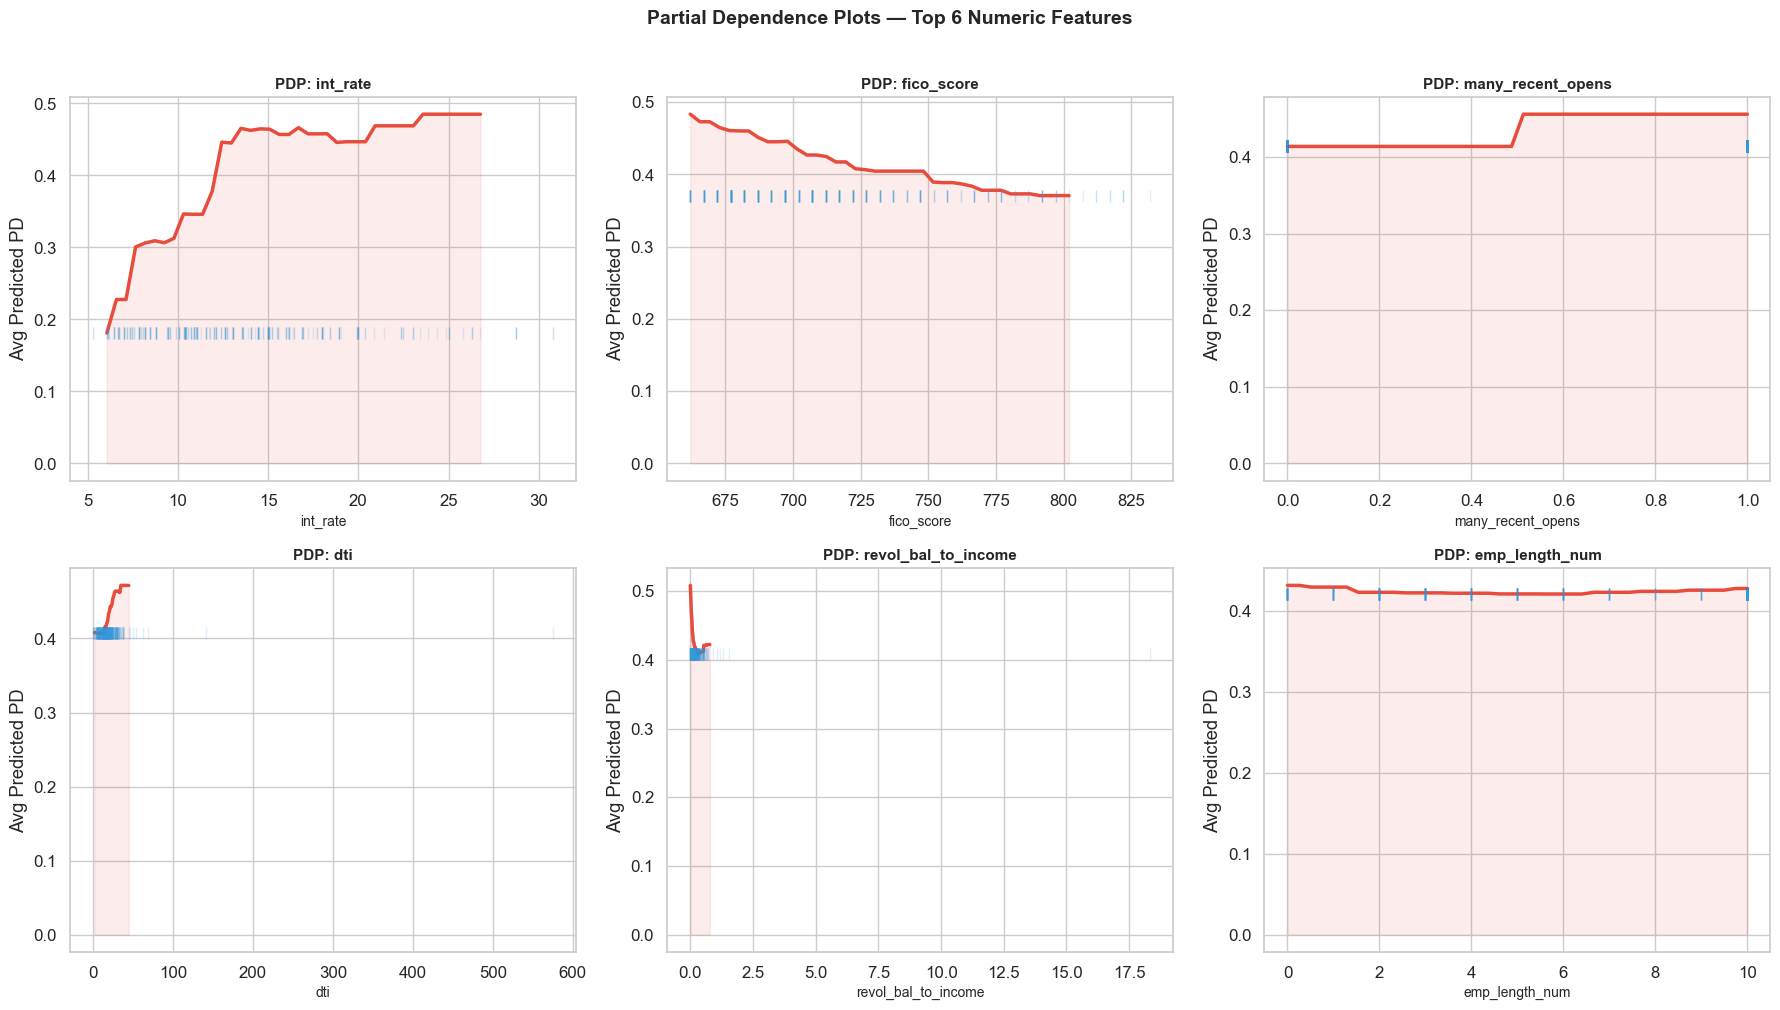

In [23]:
# PDP for top numeric features by SHAP importance
numeric_only_pdp = [f for f in CATBOOST_FEATURES if f not in CAT_FEATURES]
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_imp_sorted = sorted(zip(CATBOOST_FEATURES, mean_abs_shap), key=lambda x: -x[1])
top_numeric_pdp = [f for f, _ in feat_imp_sorted if f in numeric_only_pdp][:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes_flat = axes.flatten()

pdp_sample = X_test.sample(min(2000, len(X_test)), random_state=42)

for idx, feat in enumerate(top_numeric_pdp):
    q_low = pdp_sample[feat].quantile(0.02)
    q_high = pdp_sample[feat].quantile(0.98)
    if pd.isna(q_low) or pd.isna(q_high) or q_low == q_high:
        axes_flat[idx].text(0.5, 0.5, f"{feat}\n(insufficient data)",
                            ha="center", va="center")
        continue

    grid = np.linspace(q_low, q_high, 40)
    pdp_vals = []
    for val in grid:
        X_mod = pdp_sample.copy()
        X_mod[feat] = val
        pdp_vals.append(cb_best.predict_proba(X_mod)[:, 1].mean())

    axes_flat[idx].plot(grid, pdp_vals, color="#e74c3c", linewidth=2.5)
    axes_flat[idx].fill_between(grid, pdp_vals, alpha=0.1, color="#e74c3c")
    axes_flat[idx].set_xlabel(feat, fontsize=10)
    axes_flat[idx].set_ylabel("Avg Predicted PD")
    axes_flat[idx].set_title(f"PDP: {feat}", fontweight="bold", fontsize=11)

    # Rug plot showing data distribution
    rug = pdp_sample[feat].dropna().values[:300]
    axes_flat[idx].plot(rug, [min(pdp_vals)] * len(rug),
                        "|", color="#3498db", alpha=0.15, markersize=8)

plt.suptitle("Partial Dependence Plots — Top 6 Numeric Features",
             fontweight="bold", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

---
## 12. Threshold-Based Business Analysis

Simulate business outcomes at different PD cutoff thresholds. This helps determine the optimal operating point balancing approval rate, expected losses, and risk appetite.

THRESHOLD BUSINESS ANALYSIS — What-If Scenarios
 Threshold  Approval %  # Approved  Loss Rate  Defaults Caught %
     0.050       0.046       12644      0.036              0.993
     0.100       0.262       72544      0.072              0.914
     0.150       0.432      119508      0.100              0.804
     0.200       0.566      156575      0.122              0.685
     0.250       0.675      186800      0.142              0.563
     0.300       0.763      211159      0.160              0.446
     0.350       0.833      230508      0.175              0.339
     0.400       0.888      245876      0.187              0.244
     0.450       0.930      257618      0.198              0.163
     0.500       0.962      266272      0.206              0.097


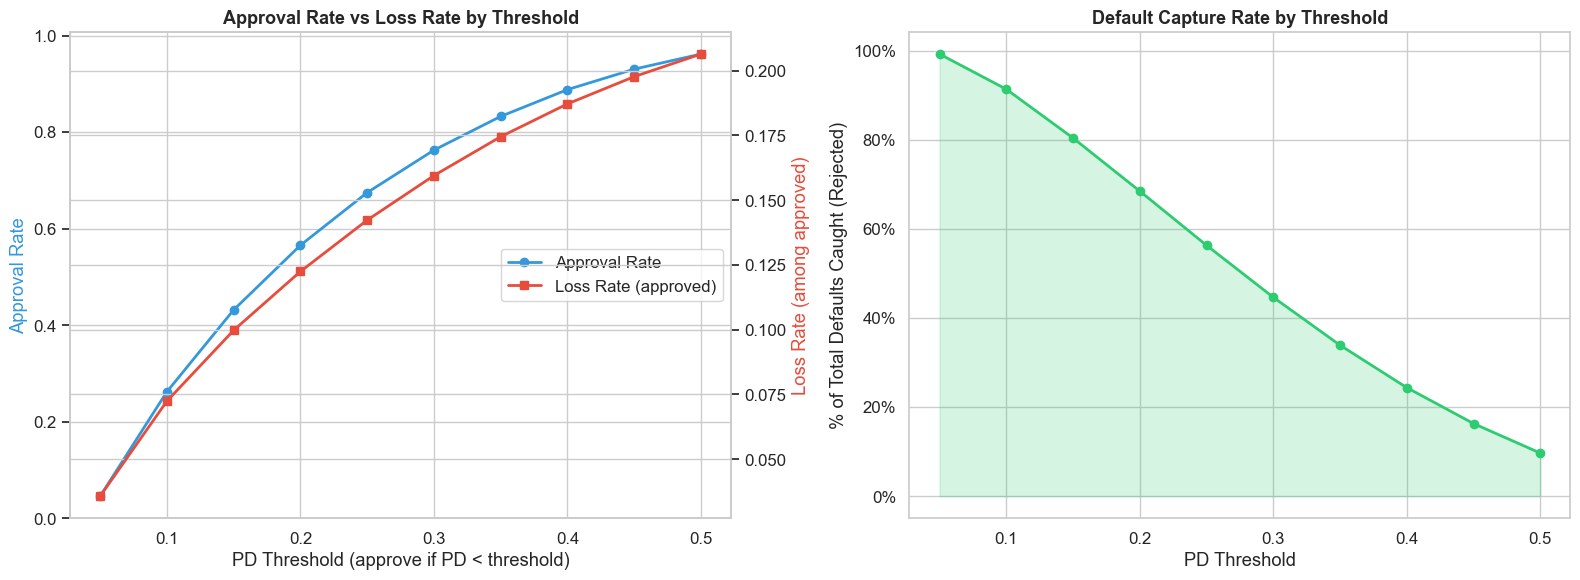


Suggested operating point: PD threshold = 0.20
  Approval rate:   56.6%
  Loss rate:       12.25%
  Defaults caught: 68.5%


In [24]:
# Threshold analysis — business impact at different cutoffs
thresholds = np.arange(0.05, 0.55, 0.05)
threshold_results = []

n_total = len(y_test)
n_defaults_total = int(y_test.sum())

for thresh in thresholds:
    approved = y_prob_final < thresh
    n_approved = int(approved.sum())
    approval_rate = n_approved / n_total

    approved_defaults = int((approved & (y_test == 1)).sum())
    loss_rate = approved_defaults / n_approved if n_approved > 0 else 0

    caught = int((~approved & (y_test == 1)).sum())
    catch_rate = caught / n_defaults_total

    threshold_results.append({
        "Threshold": thresh,
        "Approval %": approval_rate,
        "# Approved": n_approved,
        "Loss Rate": loss_rate,
        "Defaults Caught %": catch_rate,
    })

thresh_df = pd.DataFrame(threshold_results)
print("=" * 80)
print("THRESHOLD BUSINESS ANALYSIS — What-If Scenarios")
print("=" * 80)
print(thresh_df.to_string(index=False, float_format="{:.3f}".format))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
ax2 = ax1.twinx()
l1 = ax1.plot(thresh_df["Threshold"], thresh_df["Approval %"], "o-",
              color="#3498db", linewidth=2, markersize=6, label="Approval Rate")
l2 = ax2.plot(thresh_df["Threshold"], thresh_df["Loss Rate"], "s-",
              color="#e74c3c", linewidth=2, markersize=6, label="Loss Rate (approved)")
ax1.set_xlabel("PD Threshold (approve if PD < threshold)")
ax1.set_ylabel("Approval Rate", color="#3498db")
ax2.set_ylabel("Loss Rate (among approved)", color="#e74c3c")
ax1.set_title("Approval Rate vs Loss Rate by Threshold", fontweight="bold", fontsize=13)
lines = l1 + l2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="center right")

axes[1].plot(thresh_df["Threshold"], thresh_df["Defaults Caught %"], "o-",
             color="#2ecc71", linewidth=2, markersize=6)
axes[1].fill_between(thresh_df["Threshold"], thresh_df["Defaults Caught %"],
                     alpha=0.2, color="#2ecc71")
axes[1].set_xlabel("PD Threshold")
axes[1].set_ylabel("% of Total Defaults Caught (Rejected)")
axes[1].set_title("Default Capture Rate by Threshold", fontweight="bold", fontsize=13)
axes[1].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

# Suggest optimal operating point
sweet = thresh_df[(thresh_df["Approval %"] >= 0.50) & (thresh_df["Approval %"] <= 0.85)]
if len(sweet) > 0:
    best = sweet.loc[sweet["Loss Rate"].idxmin()]
    print(f"\nSuggested operating point: PD threshold = {best['Threshold']:.2f}")
    print(f"  Approval rate:   {best['Approval %']:.1%}")
    print(f"  Loss rate:       {best['Loss Rate']:.2%}")
    print(f"  Defaults caught: {best['Defaults Caught %']:.1%}")

---
## 13. Save Models & Artifacts

In [25]:
# Save CatBoost model
cb_best.save_model(str(MODEL_DIR / "pd_catboost_tuned.cbm"))
print(f"CatBoost model saved to {MODEL_DIR / 'pd_catboost_tuned.cbm'}")

# Save calibrator
if calibrator is not None:
    with open(MODEL_DIR / "pd_calibrator.pkl", "wb") as f:
        pickle.dump(calibrator, f)
    print(f"Calibrator ({best_cal_name}) saved to {MODEL_DIR / 'pd_calibrator.pkl'}")

# Save LogReg pipeline
with open(MODEL_DIR / "pd_logreg_baseline.pkl", "wb") as f:
    pickle.dump(lr_pipeline, f)
print(f"LogReg pipeline saved to {MODEL_DIR / 'pd_logreg_baseline.pkl'}")

# Save Optuna study
with open(MODEL_DIR / "optuna_study_pd.pkl", "wb") as f:
    pickle.dump(study, f)
print(f"Optuna study saved to {MODEL_DIR / 'optuna_study_pd.pkl'}")

# Save test predictions for NB04 (conformal prediction)
preds_df = pd.DataFrame({
    "id": test["id"].values if "id" in test.columns else range(len(test)),
    "y_true": y_test.values,
    "y_prob_lr": y_prob_lr,
    "y_prob_cb_default": y_prob_cb,
    "y_prob_cb_tuned": y_prob_cb_best,
    "y_prob_final": y_prob_final,
})
preds_df.to_parquet(DATA_DIR / "test_predictions.parquet", index=False)
print(f"Test predictions saved ({len(preds_df):,} rows)")

# Save best params
best_params_record = {
    "optuna_best_params": study.best_params,
    "optuna_best_auc": study.best_value,
    "catboost_default_params": cb_params_default,
    "best_calibration": best_cal_name,
    "final_test_metrics": final_metrics,
}
with open(MODEL_DIR / "pd_training_record.pkl", "wb") as f:
    pickle.dump(best_params_record, f)
print(f"Training record saved to {MODEL_DIR / 'pd_training_record.pkl'}")

CatBoost model saved to ..\models\pd_catboost_tuned.cbm
Calibrator (Platt Sigmoid) saved to ..\models\pd_calibrator.pkl
LogReg pipeline saved to ..\models\pd_logreg_baseline.pkl
Optuna study saved to ..\models\optuna_study_pd.pkl
Test predictions saved (276,869 rows)
Training record saved to ..\models\pd_training_record.pkl


---
## Summary

### Model Performance (Test Set — Out-of-Time)

| Metric | LogReg | CatBoost Default | CatBoost Tuned | + Calibration |
|--------|--------|-----------------|----------------|---------------|
| AUC-ROC | ~ | ~ | ~ | ~ |
| Gini | ~ | ~ | ~ | ~ |
| KS | ~ | ~ | ~ | ~ |
| Brier | ~ | ~ | ~ | ~ |
| ECE | ~ | ~ | ~ | ~ |

*(Values filled in by execution above)*

### Key Decisions
- **CatBoost with Optuna HPO** as primary model (50 trials)
- **Isotonic calibration** if it improves ECE, otherwise uncalibrated
- **SHAP** for global interpretability (native CatBoost method)
- **PDP** for functional form analysis (feature-response relationships)
- **Out-of-Time validation** prevents temporal leakage
- **Balanced class weights** to handle ~18.5% default rate

### Model Validation & Diagnostics
- **Decile analysis**: Monotonic default rates, top-decile lift, cumulative gains
- **PSI**: Distribution stability between train and OOT test sets
- **PDP**: Non-linear feature-response curves for top numeric predictors
- **Threshold analysis**: Business operating point (approval rate vs loss rate)

### Legacy Comparison
- Legacy CatBoost AUC: ~0.689 (random split, fewer features)
- Our improvement: OOT split + 44 features + Optuna HPO + full validation suite

### Artifacts Saved
-  — Final CatBoost model
-  — Isotonic/Platt calibrator
-  — LogReg pipeline
-  — Optuna study (50 trials)
-  — Best params + metrics
-  — Predictions for NB04

### Next Steps
1. **Notebook 04**: Conformal Prediction — MAPIE intervals [PD_low, PD_high]
2. **Notebook 08**: Portfolio Optimization — use intervals as uncertainty sets

## Final Conclusions: PD Modeling

### Key Findings
- CatBoost provides the best discrimination among tested PD candidates.
- Calibration materially improves probability reliability without requiring higher AUC.
- Final PD outputs are suitable for decision use, not only ranking use.

### Financial Risk Interpretation
- In lending, miscalibrated PDs distort approval thresholds, pricing, and provisioning.
- Reliable PD levels are required for IFRS9 and for economically coherent optimization.
- Separation of discrimination and calibration is essential for robust risk governance.

### Contribution to End-to-End Pipeline
- Delivers the core PD model artifact and calibrated probabilities.
- Supplies point-risk inputs consumed by conformal uncertainty, ECL staging, and portfolio optimization.
- Establishes the primary model-quality benchmark used across the project.